<a href="https://colab.research.google.com/github/Edesak/tensorflow-kurz/blob/main/04_transfer_learning_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning

Vezmeme exitujici model, ktery byl vytrenovan na nejaky problem a upravimeho na svuj problem (musi to byt podobny problem)

In [ ]:
!nvidia-smi


Fri Jul 16 07:13:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-07-16 07:13:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  93.4MB/s    in 1.7s    

2021-07-16 07:13:34 (93.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
!unzip /content/10_food_classes_10_percent.zip

Archive:  /content/10_food_classes_10_percent.zip
   creating: 10_food_classes_10_percent/
  inflating: __MACOSX/._10_food_classes_10_percent  
   creating: 10_food_classes_10_percent/test/
  inflating: __MACOSX/10_food_classes_10_percent/._test  
   creating: 10_food_classes_10_percent/train/
  inflating: __MACOSX/10_food_classes_10_percent/._train  
   creating: 10_food_classes_10_percent/test/ice_cream/
  inflating: __MACOSX/10_food_classes_10_percent/test/._ice_cream  
   creating: 10_food_classes_10_percent/test/chicken_curry/
  inflating: __MACOSX/10_food_classes_10_percent/test/._chicken_curry  
   creating: 10_food_classes_10_percent/test/steak/
  inflating: __MACOSX/10_food_classes_10_percent/test/._steak  
   creating: 10_food_classes_10_percent/test/sushi/
  inflating: __MACOSX/10_food_classes_10_percent/test/._sushi  
   creating: 10_food_classes_10_percent/test/chicken_wings/
  inflating: __MACOSX/10_food_classes_10_percent/test/._chicken_wings  
   creating: 10_food_class

In [ ]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} in {dirpath}")


There are 2 directories and 0 in 10_food_classes_10_percent
There are 10 directories and 0 in 10_food_classes_10_percent/test
There are 0 directories and 250 in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 in 10_food_classes_10_percent/test/pizza
There are 10 directories and 0 in 10_food_classes_10_percent/train
There are 0 directories and 75 in 10_fo

##Data loaders (prep data)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

print("Training imgs:")

train_data = train_datagen.flow_from_directory(train_dir,
                                               IMG_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")
print("Test imgs")
test_data = test_datagen.flow_from_directory(test_dir,
                                               IMG_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

Training imgs:
Found 750 images belonging to 10 classes.
Test imgs
Found 2500 images belonging to 10 classes.


##Setting up callbacks
Nejcastejsi callbacky

* Tracking experiment s tensorboard callback
* Checkpoint model callback
* Early stopping callback

In [ ]:
#Udelame tensorboard callback (potrebujeme vytvorit novy pro kazdy model)

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + str(datetime.datetime.now())
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Ukladam tensorboard logy do: {log_dir}" )
  return tensorboard_callback

##Vytvoreni modelu s TensorFlow Hub
* Zde jsou predtrenovane modely
https://tfhub.dev/
* Zorientovani se pomoci 
https://paperswithcode.com/sota

* Vybrali jsme tento model: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

* Druhy model na porovnani https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
#Import
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
#Crete model

def create_model(url,classes = 10):
  """
  Vezme tensorflow Hub a vytvori Sequential model.

  Args: 
  url (str): Tenorflow Hub URL
  num_classes (int): Pocet kategorii

  Return:
    Nezkompilovany keras Sequential model
  """
  #Stahnout model a ulozit ho jako vrtsvy
  feature_extracture_layer = hub.KerasLayer(url,
                                            trainable = False,
                                            name = "feture_extraction_layer",
                                            input_shape = IMG_SHAPE + (3,)) #Zamrazi neurony, ktere jsou uz preducene
  model = tf.keras.Sequential([
                               feature_extracture_layer,
                               layers.Dense(classes, activation="softmax", name = "output_layer")
  ])

  return model

  

In [ ]:
train_data.num_classes

10

###Resnet

In [ ]:
#Vytvoreni ResNet modelu pomoci nasi funkce

resnet_model = create_model(resnet_url,
                            classes = train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feture_extraction_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics = ["accuracy"]
)

In [ ]:
hubcallback = create_tensorboard_callback("/content/HUB","resnet_3")

Ukladam tensorboard logy do: /content/HUB/resnet_3/2021-07-16 07:42:12.462387


In [ ]:
resnet_history = resnet_model.fit(train_data,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [hubcallback])

Epoch 1/5
24/24 [==============================] - 28s 1s/step - loss: 1.7915 - accuracy: 0.4107 - val_loss: 1.1188 - val_accuracy: 0.6564
Epoch 2/5
24/24 [==============================] - 22s 936ms/step - loss: 0.8437 - accuracy: 0.7560 - val_loss: 0.8376 - val_accuracy: 0.7268
Epoch 3/5
24/24 [==============================] - 22s 930ms/step - loss: 0.5971 - accuracy: 0.8280 - val_loss: 0.7452 - val_accuracy: 0.7560
Epoch 4/5
24/24 [==============================] - 22s 933ms/step - loss: 0.4615 - accuracy: 0.8800 - val_loss: 0.6929 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 22s 925ms/step - loss: 0.3719 - accuracy: 0.9147 - val_loss: 0.6652 - val_accuracy: 0.7800


In [ ]:

def plot_loss_curves(history):
  """
  Args: 
    history: Historie natrenovaneho modelu
  Vraci oddelene grafy loss a accuracy
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs,loss, label="training_loss"),
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy, label="accuracy"),
  plt.plot(epochs, val_acc, label = "accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [ ]:
import matplotlib.pyplot as plt


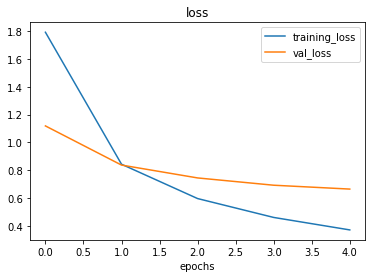

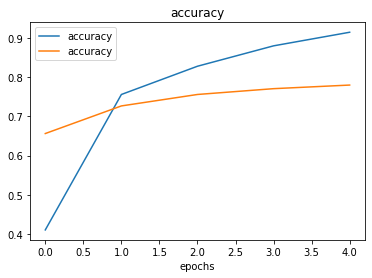

In [ ]:
plot_loss_curves(resnet_history)

###Effition Net


In [ ]:
effnet_model = create_model(efficientnet_url,train_data.num_classes)

In [ ]:
effnet_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics = ["accuracy"]
)

In [ ]:
history_eff_net=effnet_model.fit(train_data,
                 epochs = 5,
                 steps_per_epoch = len(train_data),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_tensorboard_callback("/content/HUB","effnet_1")])

Ukladam tensorboard logy do: /content/HUB/effnet_1/2021-07-16 08:02:54.143945
Epoch 1/5
24/24 [==============================] - 91s 4s/step - loss: 1.8748 - accuracy: 0.4213 - val_loss: 1.3268 - val_accuracy: 0.7312
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0653 - accuracy: 0.7560 - val_loss: 0.8755 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 19s 828ms/step - loss: 0.7485 - accuracy: 0.8360 - val_loss: 0.6992 - val_accuracy: 0.8480
Epoch 4/5
24/24 [==============================] - 19s 830ms/step - loss: 0.6016 - accuracy: 0.8653 - val_loss: 0.6086 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 19s 830ms/step - loss: 0.5057 - accuracy: 0.8853 - val_loss: 0.5579 - val_accuracy: 0.8628


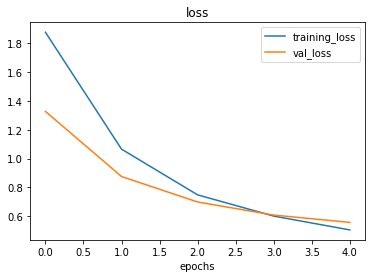

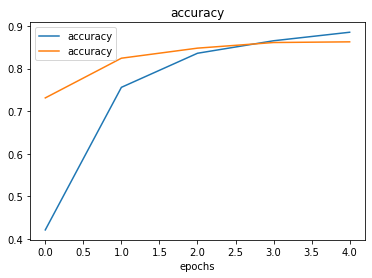

In [ ]:
plot_loss_curves(history_eff_net)

In [ ]:
effnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feture_extraction_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feture_extraction_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


##Ruzne typy transfer learning

* **As is** - Pouzivani predtrenovaneho modelu beze zmen
* **Feature extraction** - Vyuziti predtrenovaneho modelu na svuj model, upraveni vystupni vrstvy
* **Fine Tuning** - Pouziti predtrenovanych paternu a upravovani vnitrnich Vrstev (nekterych nebo vsech)

##Porovnani modelu v TensorBoardu

* Kdyz se nahravaji vysledky do Tensorboardu stavaji se verejnymi!!!
https://tensorboard.dev/

In [ ]:
#Upload to tensorboard

!tensorboard dev upload --logdir ./HUB/ --name "effnet vs resnet" --description "Porovnani Effnet a resnet" --one_shot 

2021-07-16 08:34:28.332919: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./HUB/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&sc

In [ ]:
#Nase experimenty jsou jiz publick https://tensorboard.dev/experiment/rwPOSwkJTXuGh9gdp2rPDQ/

In [ ]:
!tensorboard dev list

2021-07-16 08:39:54.598344: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/rwPOSwkJTXuGh9gdp2rPDQ/
	Name                 effnet vs resnet
	Description          Porovnani Effnet a resnet
	Id                   rwPOSwkJTXuGh9gdp2rPDQ
	Created              2021-07-16 08:35:53 (4 minutes ago)
	Updated              2021-07-16 08:36:04 (3 minutes ago)
	Runs                 9
	Tags                 5
	Scalars              102
	Tensor bytes         0
	Binary object bytes  13709551
Total: 1 experiment(s)


In [ ]:
#Delete experiment

#!tensorboard dev delete --experiment_id rwPOSwkJTXuGh9gdp2rPDQ

In [ ]:
#Potvrzeni vymazani
!tensorboard dev list 